#### 피처중요도 및 머신러닝 데이터 전처리

In [102]:
import numpy  as np
import pandas as pd

# 시각화
import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns

import json 

import warnings
warnings.filterwarnings(action='ignore')

from datetime import date, datetime, timedelta
from dateutil.parser import parse


# 한글 폰트 문제 해결
import platform

from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~') 


# 차트 축 <- 음수 부호 지원
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False


# crawling
from bs4 import BeautifulSoup
from urllib.request import urlopen , urlretrieve
from urllib.error   import HTTPError
from urllib.error   import URLError

import requests 
import re

from selenium import webdriver

from time    import sleep , time 
from random  import randint
from IPython.core.display import clear_output

# 비정형 디비 
import pymongo as mongo

# print('numpy version  - ' , np.__version__)
# print('pandas version - ' , pd.__version__)

# conda install -c conda-forge python-graphviz
# pip install graphviz

import graphviz
import missingno as msno

# ml 
import sklearn
from   sklearn.datasets import load_iris , load_breast_cancer

from   sklearn.model_selection import train_test_split , KFold , StratifiedKFold, cross_val_score , cross_validate , GridSearchCV
from   sklearn.tree            import DecisionTreeClassifier , export_graphviz
from   sklearn.metrics         import accuracy_score
from   sklearn.preprocessing   import LabelEncoder , OneHotEncoder , MinMaxScaler , StandardScaler
from   sklearn.impute          import SimpleImputer
sklearn.__version__

'0.24.2'

- GridSearchCV를 이용한 피처중요도

In [2]:
params = {
    'criterion' : ['gini' , 'entropy'] , 
    'splitter'  : ['best' , 'random']  ,
    'max_depth' : [1 , 2 , 3 ] , 
    'min_samples_split' : [2 , 3]
}

iris = load_iris() 

X_train , X_test , y_train , y_test = train_test_split(iris.data   , 
                                                       iris.target ,
                                                       test_size    = 0.25 ,
                                                       shuffle      = True , 
                                                       random_state = 200 )


dt_model = DecisionTreeClassifier(random_state = 100)

# refit -> 가장 좋은 파라미터 설정으로 재학습 시킴
grid_tree_model = GridSearchCV(dt_model , param_grid = params , cv = 3 , refit = True)
grid_tree_model.fit(X_train , y_train)
grid_tree_model.cv_results_

{'mean_fit_time': array([0.0023334 , 0.00133387, 0.00099897, 0.00133228, 0.00133157,
        0.00133443, 0.00099961, 0.00066622, 0.00066702, 0.00033323,
        0.00066725, 0.00099993, 0.00266751, 0.00099953, 0.00100009,
        0.00066646, 0.00033347, 0.00133419, 0.0010004 , 0.0013334 ,
        0.00133316, 0.00100009, 0.00066678, 0.00033323]),
 'std_fit_time': array([1.88615577e-03, 4.72607022e-04, 2.36823788e-06, 4.69515903e-04,
        4.70358870e-04, 9.43583890e-04, 8.99132768e-07, 4.71089385e-04,
        4.71651343e-04, 4.71257962e-04, 4.71820563e-04, 8.16242804e-04,
        9.41002308e-04, 2.97360213e-07, 1.12391596e-07, 4.71258002e-04,
        4.71595137e-04, 4.72719053e-04, 8.92080638e-07, 4.73112674e-04,
        4.71258967e-04, 1.12391596e-07, 4.71482786e-04, 4.71257962e-04]),
 'mean_score_time': array([0.00100017, 0.00033299, 0.00033402, 0.00033315, 0.        ,
        0.00033323, 0.        , 0.00033442, 0.00066678, 0.00066686,
        0.        , 0.00033347, 0.00066686, 0.  

In [3]:
print('최적 파라미터 - ' , grid_tree_model.best_params_ )
print('최고 점수     - ' , grid_tree_model.best_score_ )
estimator = grid_tree_model.best_estimator_
estimator

y_pred = estimator.predict(X_test)

print('GridSearchCV 테스트 정확도 - ' , accuracy_score(y_test , y_pred)) 

print()

print('answer - ' , y_test)
print()
print('pred   - ' , y_pred)

최적 파라미터 -  {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'splitter': 'best'}
최고 점수     -  0.9464201043148411
GridSearchCV 테스트 정확도 -  0.9736842105263158

answer -  [1 2 0 0 1 2 1 1 1 2 2 0 0 0 2 0 1 0 1 2 0 1 2 0 0 0 1 2 2 1 0 1 1 0 1 0 0
 0]

pred   -  [1 2 0 0 1 2 1 1 1 2 2 0 0 0 2 0 1 0 1 2 0 1 1 0 0 0 1 2 2 1 0 1 1 0 1 0 0
 0]


피처의 중요도를 시각화 - 
트리 분류 형성에 각 피처가 얼마나 잘 작용했는지를 평가하는 지표
해당 지표는 0 ~ 1 사이의 값을 가지며 , 0이면 특성이 전혀 고려되지 않을 것 - 
특성의 중요도의 합은 1 이다

feature importance -  [0.         0.         0.59075728 0.40924272]



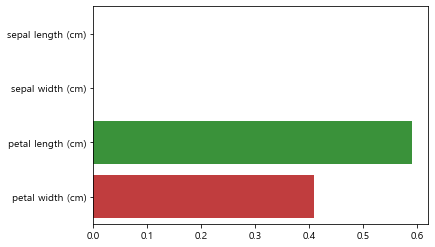


sepal length (cm) 	 0.0
sepal width (cm) 	 0.0
petal length (cm) 	 0.5907572799205508
petal width (cm) 	 0.4092427200794493


In [11]:
print('피처의 중요도를 시각화 - ') 
print('트리 분류 형성에 각 피처가 얼마나 잘 작용했는지를 평가하는 지표')
print('해당 지표는 0 ~ 1 사이의 값을 가지며 , 0이면 특성이 전혀 고려되지 않을 것 - ')
print('특성의 중요도의 합은 1 이다')
print()
print('feature importance - ' , estimator.feature_importances_)
print()

sns.barplot(x = estimator.feature_importances_ , y = iris.feature_names)

plt.show()
plt.close()

print()
for name, value in zip(iris.feature_names , estimator.feature_importances_) :
    print(name , '\t' , value)
    

- load_breast_cancer 데이터를 이용한 GridSearchCV - 피처중요도 실습

In [14]:
cancer = load_breast_cancer()
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [18]:
print('1. 데이터 프레임 만들기 - ')
cancer_frm = pd.DataFrame(data    = cancer.data , 
                          columns = cancer.feature_names)
cancer_frm['target'] = cancer.target
cancer_frm

1. 데이터 프레임 만들기 - 


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [22]:
print('DecisionTree Estimator - ') 
print('train , test : 7 , 3')
print('학습 - 예측 fit , predict')
print('모델 정확도 평가 - accuracy_score')
print()

X_train , X_test , y_train , y_test = train_test_split(cancer.data   , 
                                                       cancer.target ,
                                                       test_size    = 0.3 ,
                                                       shuffle      = True , 
                                                       random_state = 200 )

X_train.shape , X_test.shape , y_train.shape , y_test.shape

DecisionTree Estimator - 
train , test : 7 , 3
학습 - 예측 fit , predict
모델 정확도 평가 - accuracy_score



((398, 30), (171, 30), (398,), (171,))

In [25]:
cancer_model = DecisionTreeClassifier()
cancer_model.fit(X_train, y_train) 

print('predict 함수에 테스트 데이터를 넣어서 분류예측 값을 반환 - ')
y_pred = cancer_model.predict(X_test)
print('answer - ' , y_test)
print('pred   - ' , y_pred) 

predict 함수에 테스트 데이터를 넣어서 분류예측 값을 반환 - 
answer -  [1 0 1 1 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 1
 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1
 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1
 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0]
pred   -  [1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1
 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1
 0 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1
 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0]


In [26]:
print('성능평가 - ') 
print('예측 정확도 - ' , accuracy_score(y_test , y_pred) )

성능평가 - 
예측 정확도 -  0.9415204678362573


In [44]:
print('graphvis 트리 시각화 - ') 
# export_graphviz(cancer_model , 
#                 out_file      = 'cancer_tree.dot' , 
#                 class_names   = cancer.target_names , 
#                 feature_names = cancer.feature_names ,
#                 impurity = True , 
#                 filled   = True)
# 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'splitter': 'best'
graph_cancer_model = DecisionTreeClassifier(criterion         = 'gini', 
                                      max_depth         = 3,
                                      min_samples_split = 2,
                                      splitter          = 'best') 
graph_cancer_model.fit(X_train, y_train) 
export_graphviz(graph_cancer_model , 
                out_file      = 'cancer_tree.dot' , 
                class_names   = cancer.target_names , 
                feature_names = cancer.feature_names ,
                impurity = True , 
                filled   = True)

graphvis 트리 시각화 - 


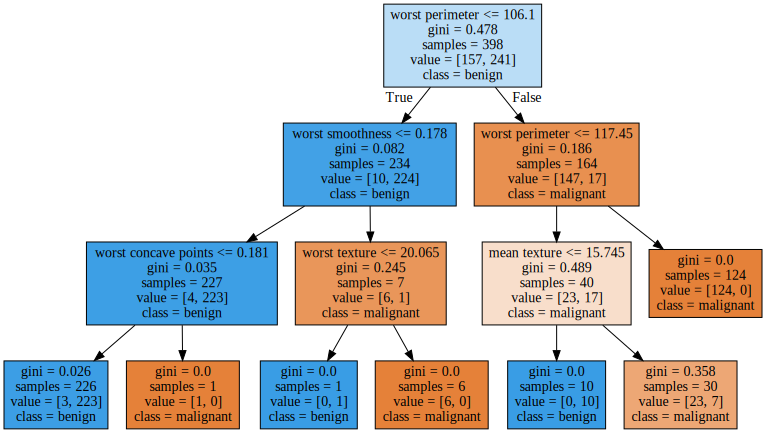

In [45]:
import os 

os.environ['PATH'] += os.pathsep + 'C:/Program Files/Graphviz/bin'

with open('./cancer_tree.dot') as file :
    cancer_graph = file.read()

graphviz.Source(cancer_graph)

In [47]:
print('GridSearchCV 파라미터 튜닝 - ') 
print('피처 중요도 시각화 - ') 

params = {
    'criterion' : ['gini' , 'entropy'] , 
    'splitter'  : ['best' , 'random']  ,
    'max_depth' : [1 , 2 , 3 ] , 
    'min_samples_split' : [2 , 3]
}

# refit -> 가장 좋은 파라미터 설정으로 재학습 시킴
grid_tree_model = GridSearchCV(cancer_model , param_grid = params , cv = 3 , refit = True)
grid_tree_model.fit(X_train , y_train)
grid_tree_model.cv_results_





GridSearchCV 파라미터 튜닝 - 
피처 중요도 시각화 - 


{'mean_fit_time': array([0.00333095, 0.00100088, 0.0019993 , 0.00100048, 0.00299835,
        0.00066678, 0.00233181, 0.00066662, 0.00332959, 0.00033339,
        0.00300026, 0.00066622, 0.00199898, 0.00066622, 0.00133332,
        0.0006671 , 0.0029997 , 0.00033387, 0.00333214, 0.00033426,
        0.00299939, 0.00133443, 0.00366521, 0.00066686]),
 'std_fit_time': array([1.24655635e-03, 0.00000000e+00, 6.25769923e-07, 8.16729452e-04,
        7.78671819e-07, 4.71482786e-04, 4.69628294e-04, 4.71370394e-04,
        4.66256628e-04, 4.71482745e-04, 1.94667955e-07, 4.71090189e-04,
        7.86741172e-07, 4.71089867e-04, 4.71145731e-04, 4.71707569e-04,
        1.10692885e-06, 4.72157095e-04, 1.24872219e-03, 4.72719053e-04,
        8.17119437e-04, 4.72044864e-04, 4.70696044e-04, 4.71538951e-04]),
 'mean_score_time': array([0.00066678, 0.0006671 , 0.0006663 , 0.00100144, 0.0010004 ,
        0.00033347, 0.00100104, 0.0003341 , 0.00066733, 0.00066646,
        0.        , 0.00033307, 0.00100319, 0.00

GridSearchCV 테스트 정확도 -  0.935672514619883

answer -  [1 0 1 1 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 1
 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1
 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1
 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0]

pred   -  [1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1
 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1
 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1
 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1
 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 1 0 0]
피처의 중요도를 시각화 - 
트리 분류 형성에 각 피처가 얼마나 잘 작용했는지를 평가하는 지표
해당 지표는 0 ~ 1 사이의 값을 가지며 , 0이면 특성이 전혀 고려되지 않을 것 - 
특성의 중요도의 합은 1 이다

feature importance -  [0.         0.         0.04843159 0.         0.         0.
 0.         0.         0.         0.  

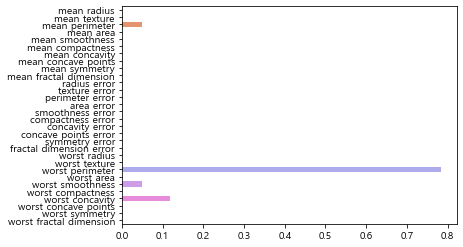


mean radius 	 0.0
mean texture 	 0.0
mean perimeter 	 0.04843159116651358
mean area 	 0.0
mean smoothness 	 0.0
mean compactness 	 0.0
mean concavity 	 0.0
mean concave points 	 0.0
mean symmetry 	 0.0
mean fractal dimension 	 0.0
radius error 	 0.0
texture error 	 0.0
perimeter error 	 0.0
area error 	 0.0
smoothness error 	 0.0
compactness error 	 0.0
concavity error 	 0.0
concave points error 	 0.0
symmetry error 	 0.0
fractal dimension error 	 0.0
worst radius 	 0.0
worst texture 	 0.0
worst perimeter 	 0.7832518235044656
worst area 	 0.0
worst smoothness 	 0.04951334069190041
worst compactness 	 0.0
worst concavity 	 0.1188032446371204
worst concave points 	 0.0
worst symmetry 	 0.0
worst fractal dimension 	 0.0


In [48]:
estimator = grid_tree_model.best_estimator_
estimator

y_pred = estimator.predict(X_test)

print('GridSearchCV 테스트 정확도 - ' , accuracy_score(y_test , y_pred)) 

print()

print('answer - ' , y_test)
print()
print('pred   - ' , y_pred)


print('피처의 중요도를 시각화 - ') 
print('트리 분류 형성에 각 피처가 얼마나 잘 작용했는지를 평가하는 지표')
print('해당 지표는 0 ~ 1 사이의 값을 가지며 , 0이면 특성이 전혀 고려되지 않을 것 - ')
print('특성의 중요도의 합은 1 이다')
print()
print('feature importance - ' , estimator.feature_importances_)
print()

sns.barplot(x = estimator.feature_importances_ , y = cancer.feature_names)

plt.show()
plt.close()

print()
for name, value in zip(cancer.feature_names , estimator.feature_importances_) :
    print(name , '\t' , value)
    

#### 데이터 전처리
- 데이터 인코딩(ml 문자열값을 입력값으로 허용하지 않는다) -> 숫자형 변환
- 레이블 인코딩 , 원-핫-인코딩
- 주의사항) 회귀 X , 트리계열의 알고리즘에서는 적용(성능이 떨어지는 단점, 왜냐하면 숫자의 특성이 반영되기 때문에)

- 입력값은 결측값을 허용하지 않는다 -> 고정된 다른값으로 변환
- 이상치

- 피처 스케일링 : 정규화(0과 1 사이의 값으로 변환) , 표준화(정규분포를 따르는 형식 평균 0 분산 1 가우시안 분포)
- 정규화 : MinMaxScalar
- 표준화 : StandardScalar

- 레이블인코딩은 문자를 숫자로 변환 : LabelEncoder : fit() , transform() , fit_transform()

In [54]:
label_items = ['낫또' , '집밥' , 'ABC 쥬스' , '육계장 칼국수' , '낫또']
encoder = LabelEncoder()
label_digit = encoder.fit(label_items).transform(label_items)
print('digit - ' , label_digit)
print('label - ' , encoder.classes_)
print('label - ' , encoder.inverse_transform([1, 3, 0, 2, 1]))

digit -  [1 3 0 2 1]
label -  ['ABC 쥬스' '낫또' '육계장 칼국수' '집밥']
label -  ['낫또' '집밥' 'ABC 쥬스' '육계장 칼국수' '낫또']


- 원-핫 인코딩

In [65]:
label_items = ['낫또' , '집밥' , 'ABC 쥬스' , '육계장 칼국수' , '낫또']
encoder = LabelEncoder()
label_digit = encoder.fit(label_items).transform(label_items)

print('digit - ' , label_digit)
print('type - ' , type(label_digit))


print('2차원 데이터 변환 - ')
reshape_label_digit = label_digit.reshape(-1, 1)
print(reshape_label_digit.shape)
print(reshape_label_digit)

print('item -> digit -> one-hot encoding')
one_hot_encoder = OneHotEncoder()
one_hot_encoder_label = one_hot_encoder.fit(reshape_label_digit).transform(reshape_label_digit)
print('shape - ' , one_hot_encoder_label.shape)
print(one_hot_encoder_label.toarray() )


digit -  [1 3 0 2 1]
type -  <class 'numpy.ndarray'>
2차원 데이터 변환 - 
(5, 1)
[[1]
 [3]
 [0]
 [2]
 [1]]
item -> digit -> one-hot encoding
shape -  (5, 4)
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


In [66]:
encoder_frm = pd.DataFrame({
    'label_items' : ['낫또' , '집밥' , 'ABC 쥬스' , '육계장 칼국수' , '낫또']
})
pd.get_dummies(encoder_frm)

,label_items_ABC 쥬스,label_items_낫또,label_items_육계장 칼국수,label_items_집밥
0,0,1,0,0
1,0,0,0,1
2,1,0,0,0
3,0,0,1,0
4,0,1,0,0


- 결측치 시각화
- conda install -c conda-forge/label/cf202003 missingno

In [68]:
from io import StringIO

csv_data = StringIO("""
x1,x2,x3,x4,x5
1,0.1,"1",2019-01-01,A
2,,,2019-01-02,B
3,,"3",2019-01-03,C
,0.4,"4",2019-01-04,A
5,0.5,"5",2019-01-05,B
,,,2019-01-06,C
7,0.7,"7",,A
8,0.8,"8",2019-01-08,B
9,0.9,,2019-01-09,C
""")

In [69]:
df = pd.read_csv(csv_data)
df

,x1,x2,x3,x4,x5
0,1.0,0.1,1.0,2019-01-01,A
1,2.0,NaN,NaN,2019-01-02,B
2,3.0,NaN,3.0,2019-01-03,C
3,NaN,0.4,4.0,2019-01-04,A
4,5.0,0.5,5.0,2019-01-05,B
5,NaN,NaN,NaN,2019-01-06,C
6,7.0,0.7,7.0,NaN,A
7,8.0,0.8,8.0,2019-01-08,B
8,9.0,0.9,NaN,2019-01-09,C


<AxesSubplot:>

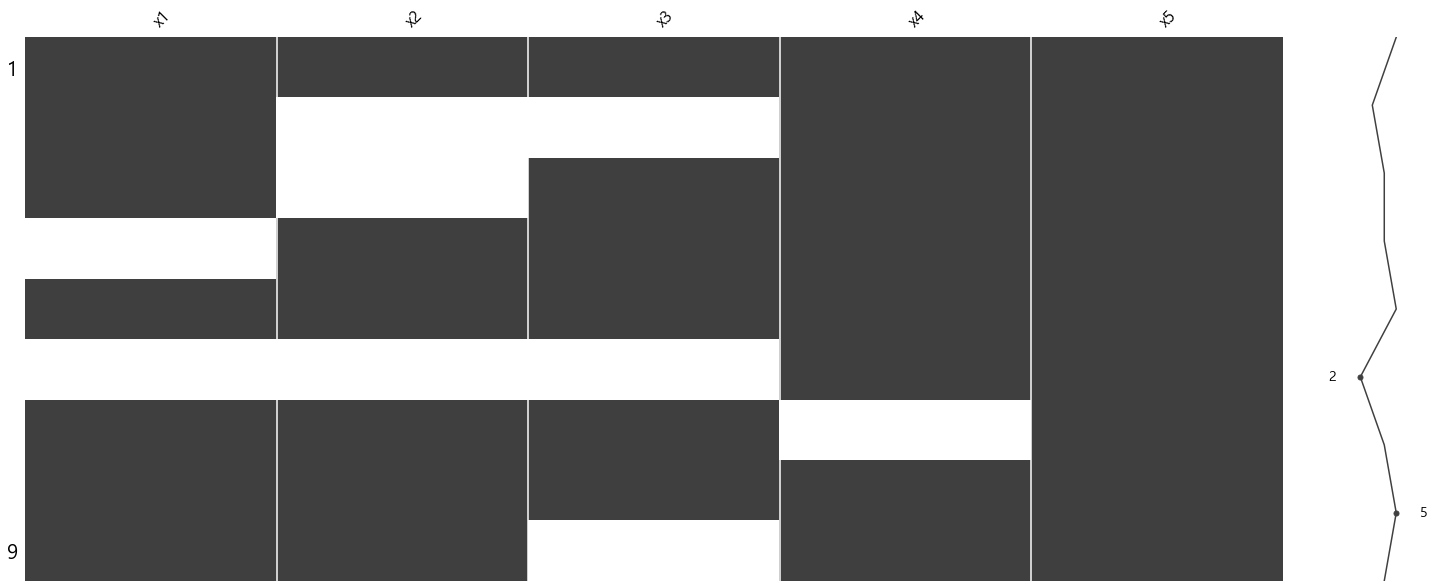

In [74]:
msno.matrix(df)

<AxesSubplot:>

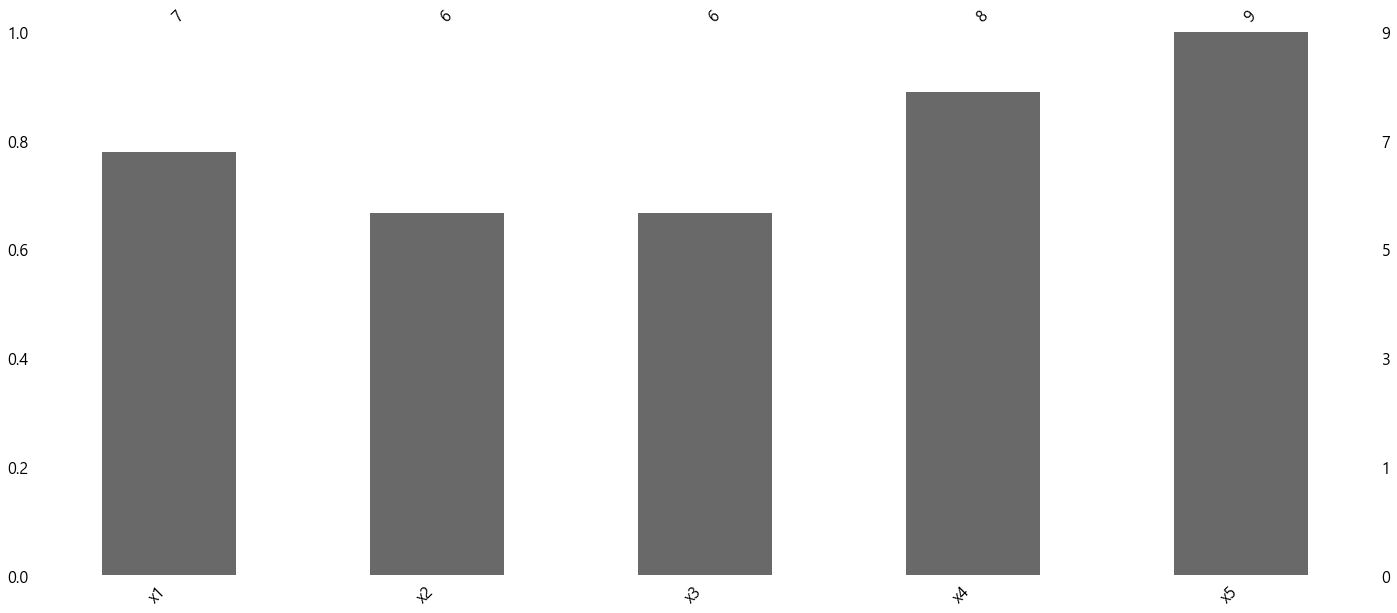

In [75]:
msno.bar(df)

In [98]:
titanic = sns.load_dataset('titanic')
titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


<AxesSubplot:>

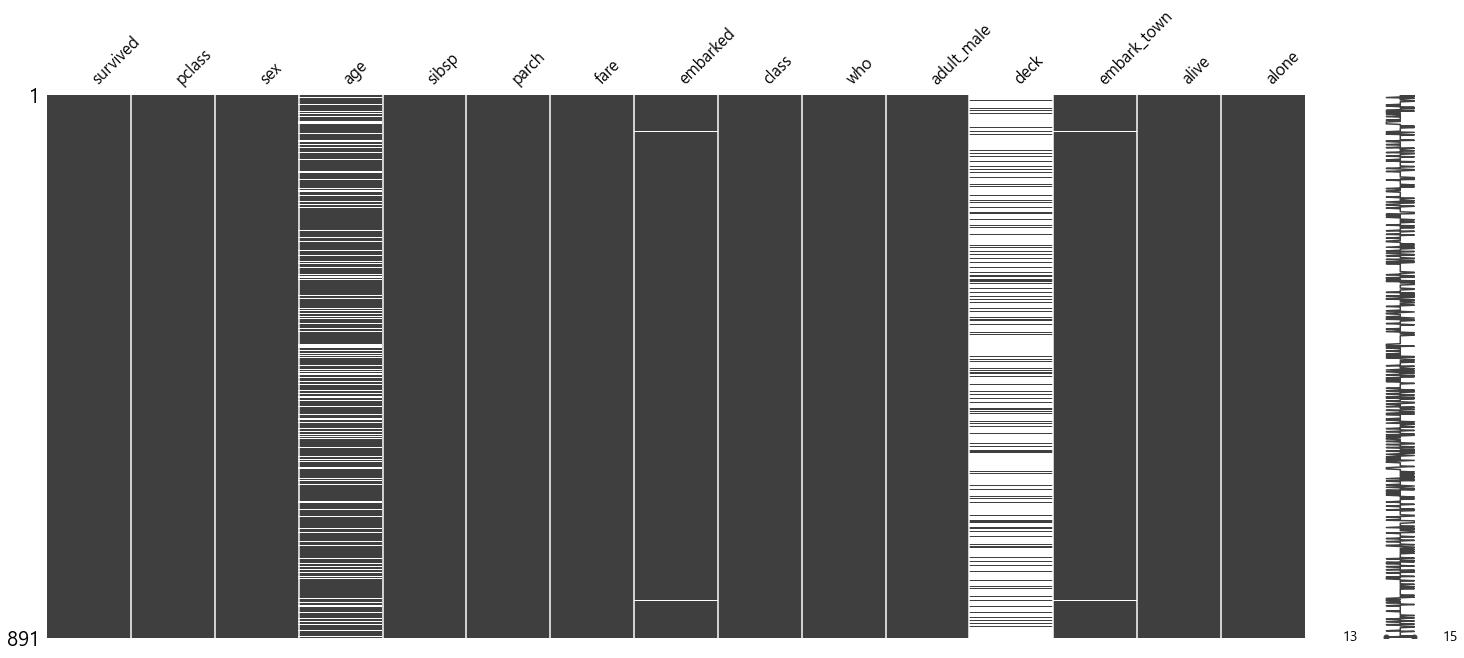

In [89]:
msno.matrix(titanic)

In [93]:
titanic['deck'].value_counts()

G    692
C     59
B     47
D     33
E     32
A     15
F     13
Name: deck, dtype: int64

In [80]:
titanic['age'].value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: age, Length: 88, dtype: int64

In [90]:
print('age - 평균 대체한다면? SimpleImputer')
# strategy = mean , median , most_frequent

titanic_age_imputer = SimpleImputer(strategy = 'mean')
titanic['age'] = titanic_age_imputer.fit_transform(titanic[['age']])

age - 평균 대체한다면? SimpleImputer


<AxesSubplot:>

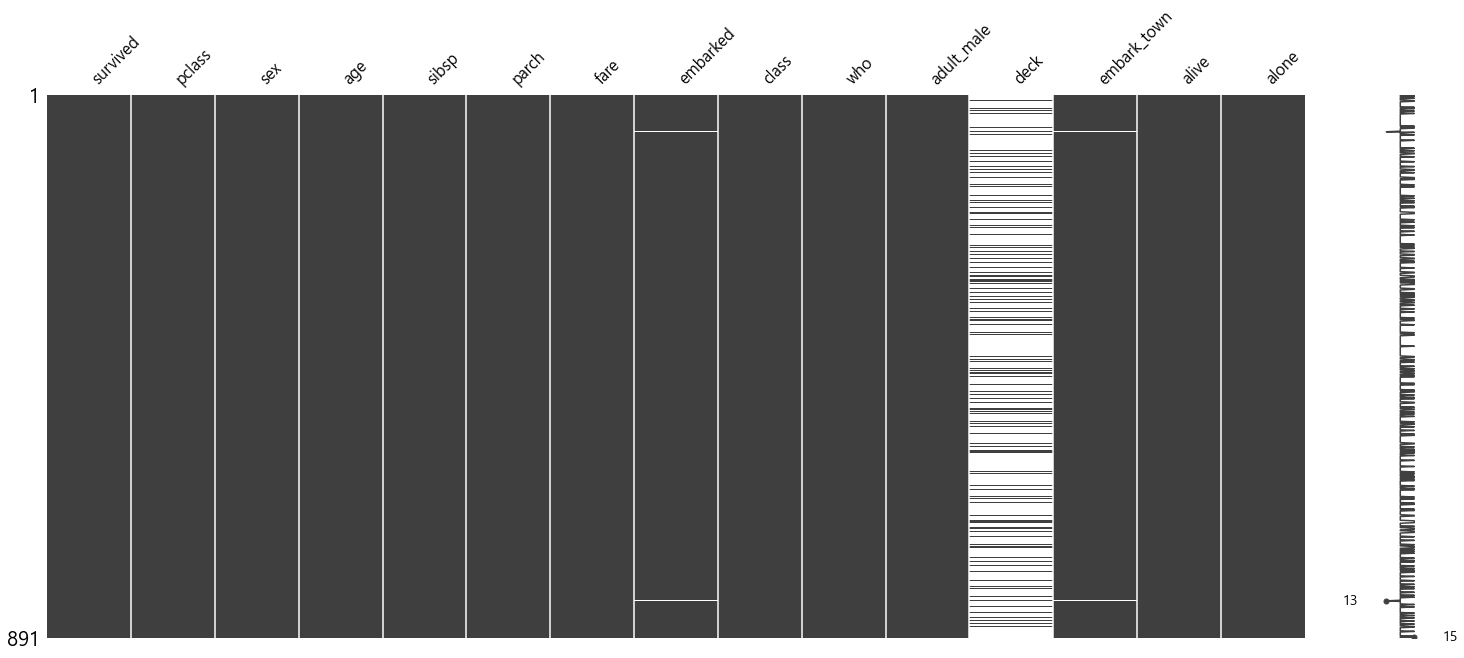

In [91]:
msno.matrix(titanic)

In [84]:
print('deck - 최빈값으로 대체한다면? SimpleImputer')
# strategy = mean , median , most_frequent

titanic_age_imputer = SimpleImputer(strategy = 'most_frequent')
titanic['deck'] = titanic_age_imputer.fit_transform(titanic[['deck']])

deck - 최빈값으로 대체한다면? SimpleImputer


deck - 결측값을 G 값으로 대체한다면? 


<AxesSubplot:>

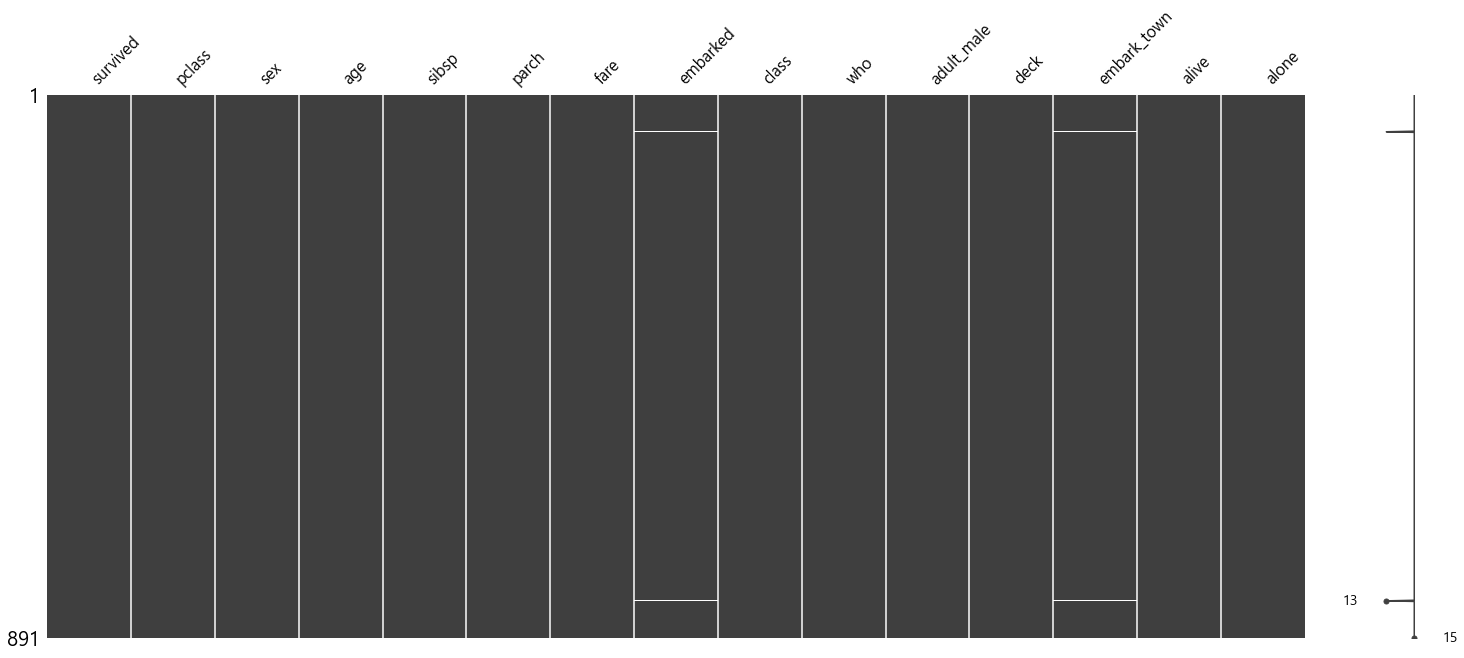

In [92]:
print('deck - 결측값을 G 값으로 대체한다면? ')

titanic['deck'] =  titanic['deck'].fillna('G')
msno.matrix(titanic)

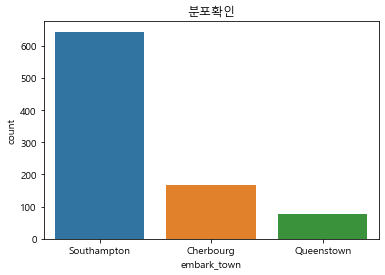

In [95]:
sns.countplot(titanic.embark_town)

plt.title('분포확인')
plt.show()
plt.close()

embark_town , embarked - 최빈값으로 대체한다면? SimpleImputer


<AxesSubplot:>

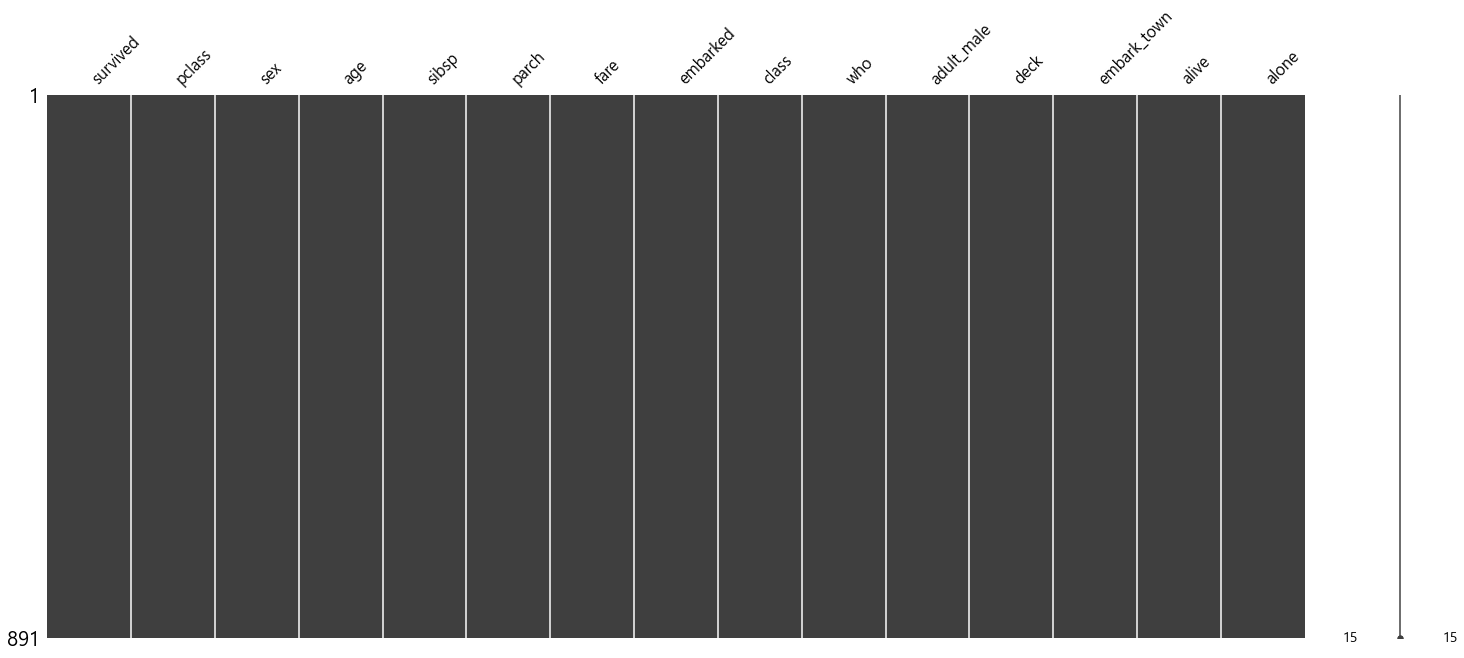

In [97]:
print('embark_town , embarked - 최빈값으로 대체한다면? SimpleImputer')

titanic_age_imputer = SimpleImputer(strategy = 'most_frequent')
titanic['embark_town'] = titanic_age_imputer.fit_transform(titanic[['embark_town']])
titanic['embarked'] = titanic_age_imputer.fit_transform(titanic[['embarked']])

msno.matrix(titanic)

데이터의 분포를 확인할 때 


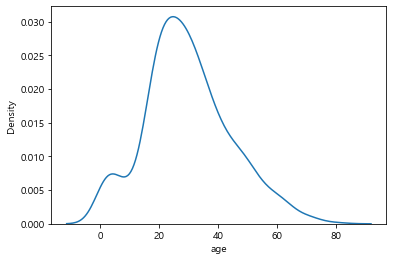

In [99]:
print('데이터의 분포를 확인할 때 ')

sns.kdeplot(titanic.age)

plt.show()
plt.close()

- Featuer Scaling
- 정규화 (x - x최소값) / (x최대값 - x최소값) -> MinMaxScaler
- 표준화 (x - x평균값) / (x표준편차) -> StandardScaler

In [110]:
iris_frm = pd.DataFrame(data    = iris.data , 
                        columns = iris.feature_names)

print('mean - ')
print( iris_frm.mean() )
print()
print('std - ')
print( iris_frm.std() )
print()
print('var - ')
print( iris_frm.var() )

mean - 
sepal length (cm)    5.843333
sepal width (cm)     3.057333
petal length (cm)    3.758000
petal width (cm)     1.199333
dtype: float64

std - 
sepal length (cm)    0.828066
sepal width (cm)     0.435866
petal length (cm)    1.765298
petal width (cm)     0.762238
dtype: float64

var - 
sepal length (cm)    0.685694
sepal width (cm)     0.189979
petal length (cm)    3.116278
petal width (cm)     0.581006
dtype: float64


In [111]:
iris_frm

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [114]:
print('표준화 - ') 
s_scaler = StandardScaler()
s_iris = s_scaler.fit_transform(iris_frm)
s_iris

standard_iris_frm = pd.DataFrame(data    = s_iris, 
                                 columns = iris.feature_names)

standard_iris_frm

표준화 - 


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444
...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832
146,0.553333,-1.282963,0.705921,0.922303
147,0.795669,-0.131979,0.819596,1.053935
148,0.432165,0.788808,0.933271,1.448832


In [116]:
print('정규화 - ') 
m_scaler = MinMaxScaler()

m_iris = m_scaler.fit_transform(iris_frm)
m_iris

m_iris_frm = pd.DataFrame(data    = m_iris, 
                                 columns = iris.feature_names)

m_iris_frm

정규화 - 


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667
...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667
146,0.555556,0.208333,0.677966,0.750000
147,0.611111,0.416667,0.711864,0.791667
148,0.527778,0.583333,0.745763,0.916667


- 스케일링 전후 정확도를 비교 [실습]
- https://raw.githubusercontent.com/rasbt/pattern_classification/master/data/wine_data.csv

In [123]:
tmp_frm = pd.read_csv('https://raw.githubusercontent.com/rasbt/pattern_classification/master/data/wine_data.csv' , 
                      header = None , 
                      usecols = [0, 2, 13])
tmp_frm.columns = ['target' , 'x' , 'y']
tmp_frm


,target,x,y
0,1,1.71,1065
1,1,1.78,1050
2,1,2.36,1185
3,1,1.95,1480
4,1,2.59,735
...,...,...,...
173,3,5.65,740
174,3,3.91,750
175,3,4.28,835
176,3,2.59,840


In [124]:
print('스케일링 전 학습을 시켜보자 - model case 01')

X_train , X_test , y_train , y_test = train_test_split(tmp_frm[['x','y']], 
                                                       tmp_frm['target'] ,
                                                       test_size    = 0.25 ,
                                                       shuffle      = True , 
                                                       random_state = 200 )

tmp_model = DecisionTreeClassifier()
tmp_model.fit(X_train,y_train)

y_pred = tmp_model.predict(X_test)

print('성능평가 - ')
print('모델 정확도 - ',accuracy_score(y_test,y_pred))



스케일링 전 학습을 시켜보자 - model case 01
성능평가 - 
모델 정확도 -  0.7555555555555555


In [129]:
print('스케일링 후 학습을 시켜보자 - model case 02')
print('주의사항이 있음 - 샘플코드를 통해서 확인해 보자 - ')
print()
print('문제점을 파악해 보자 - ')

train_data = np.arange(0, 11).reshape(-1, 1)
print('train - ')
print(train_data)

test_data = np.arange(0, 6).reshape(-1, 1)
print('test - ')
print(test_data)


스케일링 후 학습을 시켜보자 - model case 02
주의사항이 있음 - 샘플코드를 통해서 확인해 보자 - 

문제점을 파악해 보자 - 
train - 
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]]
test - 
[[0]
 [1]
 [2]
 [3]
 [4]
 [5]]


In [132]:
print('학습 데이터의 정규화 - ') 
scaler = MinMaxScaler()
scaler.fit(train_data) 

s_train_data = scaler.transform(train_data) 
print('원본 데이터   - ' , train_data.reshape(-1))
print('정규화 데이터 - ' , s_train_data.reshape(-1))

학습 데이터의 정규화 - 
원본 데이터   -  [ 0  1  2  3  4  5  6  7  8  9 10]
정규화 데이터 -  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [133]:
print('테스트 데이터의 정규화 - ') 

scaler.fit(test_data) 

s_test_data = scaler.transform(test_data) 

print('원본 데이터   - ' , test_data.reshape(-1))
print('정규화 데이터 - ' , s_test_data.reshape(-1))

테스트 데이터의 정규화 - 
원본 데이터   -  [0 1 2 3 4 5]
정규화 데이터 -  [0.  0.2 0.4 0.6 0.8 1. ]


In [135]:
print('위와 같은 실수를 범하면 안된다!! 그래서 스케일링 기준은 학습데이터를 기준으로 테스데이터를 스케일해야함!!!')
print()

scaler = MinMaxScaler()
scaler.fit(train_data) 

s_train_data = scaler.transform(train_data) 
print('원본 데이터   - ' , train_data.reshape(-1))
print('정규화 데이터 - ' , s_train_data.reshape(-1))



s_test_data = scaler.transform(test_data) 

print('원본 데이터   - ' , test_data.reshape(-1))
print('정규화 데이터 - ' , s_test_data.reshape(-1))



위와 같은 실수를 범하면 안된다!! 그래서 스케일링 기준은 학습데이터를 기준으로 테스데이터를 스케일해야함!!!

원본 데이터   -  [ 0  1  2  3  4  5  6  7  8  9 10]
정규화 데이터 -  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
원본 데이터   -  [0 1 2 3 4 5]
정규화 데이터 -  [0.  0.1 0.2 0.3 0.4 0.5]


In [138]:
X_train , X_test , y_train , y_test = train_test_split(tmp_frm[['x','y']], 
                                                       tmp_frm['target'] ,
                                                       test_size    = 0.25 ,
                                                       shuffle      = True , 
                                                       random_state = 200 )

scaler = MinMaxScaler()
scaler.fit(X_train) 

m_train_data = scaler.transform(X_train)
m_test_data = scaler.transform(X_test)


tmp_model = DecisionTreeClassifier()
tmp_model.fit(m_train_data , y_train)

y_pred = tmp_model.predict(m_test_data)

print('answer - ' , y_test.values)
print()
print('guess  - ' , y_pred)
print()

print('성능평가 - ')
print('모델 정확도 - ',accuracy_score(y_test,y_pred))


answer -  [2 1 3 3 3 3 3 2 1 1 2 2 3 3 1 3 1 2 1 1 2 2 2 2 2 1 3 1 1 1 3 3 2 2 3 2 3
 1 2 2 1 1 3 1 2]

guess  -  [2 1 3 2 3 3 1 3 1 1 3 2 3 3 1 2 2 3 1 2 2 2 2 2 2 1 2 1 1 1 2 3 2 2 3 2 3
 1 2 2 1 3 3 1 2]

성능평가 - 
모델 정확도 -  0.7555555555555555
